# Mock AlphaGo (2) - Policy Network
In this notebook, we will build the model of AlphaGo's Policy Network, which is a dCNN.

In [1]:
import os, numpy as np
from caffe2.python import core, model_helper, workspace, brew, utils
from caffe2.proto import caffe2_pb2

%matplotlib inline
from matplotlib import pyplot

CONV_LEVEL = 13 # [3,13(alphago)] How many CNN will be used in the model
FILTERS = 192 # 128/192(alphago)/256/384 How many K will be used in the model
BASE_LR = -0.002 # (-0.01,0) The base Learning Rate, alphago uses -0.003 and half the number every 80m steps

if workspace.has_gpu_support:
    device_opts = core.DeviceOption(caffe2_pb2.CUDA, workspace.GetDefaultGPUID())
    print('Running in GPU mode on default device {}'.format(workspace.GetDefaultGPUID()))
else :
    device_opts = core.DeviceOption(caffe2_pb2.CPU, 0)
    print('Running in CPU mode')

TRAIN_BATCHES = 64 # how many samples will be trained within one mini-batch, depends on your hardware
PRE_TRAINED_ITERS = 1500000 # [0, infinity) how many batches the model has been trained before
SKIP_TRAINED_DATA = 0 # [0, infinity) if this is a resumed training, how many input data will be skipped
TRAIN_ITERS = 500000 # [0, infinity) how many batches the model will be trained
TEST_BATCHES = 100 # how many samples will be tested within one mini-batch
TEST_ITERS = 3000 # how many batches the model will be tested

ROOT_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','go','param') # folder stores the loss/accuracy log
DATA_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','go')
TRAIN_DATA = os.path.join(DATA_FOLDER,'train_data') # db folder stores the preprocessed games
TEST_DATA = os.path.join(DATA_FOLDER,'test_data') # db folder stores the preprocessed games

# if this is a resumed training, where to load the init_param from
LOAD_FOLDER = os.path.join(ROOT_FOLDER, "conv={}-k={}-iter={}".format(CONV_LEVEL,FILTERS,PRE_TRAINED_ITERS))

# if the model will be saved for future resume training, where to store it
SAVE_FOLDER = os.path.join(ROOT_FOLDER, "conv={}-k={}-iter={}".format(CONV_LEVEL,FILTERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

workspace.ResetWorkspace(ROOT_FOLDER)

print('Training model from {} to {} iterations'.format(PRE_TRAINED_ITERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

Running in GPU mode on default device 0
Training model from 1500000 to 2000000 iterations


## AlphaGo Neural Network Architecture
Refer to AlphaGo
> The input to the policy network is a 19 x 19 x 48 image stack consisting of 48 feature planes. The first hidden layer zero-pads the input into a 23 x 23 image, then convolves k filters of kernel size 5 x 5 with stride 1 with the input image and applies a rectifier nonlinearity. Each of the subsequent hidden layers 2 to 12 zero pads the respective previous hidden layer into a 21 x 21 image, then convolves k filters of kernel size 3x3 with stride 1, again followed by a rectifier nonlinearity. The final layer convolves 1 filter of kernel size 1 x 1 with stride 1, with a different bias for each position, and applies a softmax function.

### Data Input
This program requires input data in shape of 48 x 19 x 19, which is preprocessed from SGF files, and label of scalar, which represents the next move.
    The board of Go is symmetric in 8 directions, so this method can be enhanced to transpose and mirror the input data in 8 directions. According to DeepMind, training the model with symmetric data in 8 directions will increase the accuracy data by around 1-2% which is significant. However, it also takes 8 times longer to train the model. Spending same amount of time in Reinforced Training instead of symmetric data may achieve better winning rate. AlphaGo didn't use the symmetric data for training.

In [2]:
def AddInput(model, batch_size, db, db_type):
    # Data is stored in INT8 while label is stored in UINT16
    # This will save disk storage
    data_int8, label_uint16 = model.TensorProtosDBInput(
        [], ['data_int8', 'label_uint16'], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast to float
    data = model.Cast(data_int8, 'data', to=core.DataType.FLOAT)
    # cast to int
    label_int32 = model.Cast(label_uint16, 'label_int32', to=core.DataType.INT32)
    label = model.FlattenToVec(label_int32, 'label')
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    label = model.StopGradient(label, label)
    return data, label

### DCNN

In [3]:
def AddConvModel(model, data):
    # Layer 1: 48 x 19 x 19 -pad-> 48 x 23 x 23 -conv-> 192 x 19 x 19
    pad1 = model.PadImage(data, 'pad1', pad_t=2, pad_l=2, pad_b=2, pad_r=2, mode="constant", value=0.)
    conv1 = brew.conv(model, pad1, 'conv1', dim_in=48, dim_out=FILTERS, kernel=5)
    relu1 = brew.relu(model, conv1, 'relu1')
    # Layer 2-12: 192 x 19 x 19 -pad-> 192 x 21 x 21 -conv-> 192 x 19 x 19
    if CONV_LEVEL > 2:
        pad2 = model.PadImage(relu1, 'pad2', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv2 = brew.conv(model, pad2, 'conv2', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu2 = brew.relu(model, conv2, 'relu2')
        relu = relu2
    #
    if CONV_LEVEL > 3:
        pad3 = model.PadImage(relu2, 'pad3', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv3 = brew.conv(model, pad3, 'conv3', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu3 = brew.relu(model, conv3, 'relu3')
        relu = relu3
    #
    if CONV_LEVEL > 4:
        pad4 = model.PadImage(relu3, 'pad4', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv4 = brew.conv(model, pad4, 'conv4', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu4 = brew.relu(model, conv4, 'relu4')
        relu = relu4
    #
    if CONV_LEVEL > 5:
        pad5 = model.PadImage(relu4, 'pad5', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv5 = brew.conv(model, pad5, 'conv5', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu5 = brew.relu(model, conv5, 'relu5')
        relu = relu5
    #
    if CONV_LEVEL > 6:
        pad6 = model.PadImage(relu5, 'pad6', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv6 = brew.conv(model, pad6, 'conv6', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu6 = brew.relu(model, conv6, 'relu6')
        relu = relu6
    #
    if CONV_LEVEL > 7:
        pad7 = model.PadImage(relu6, 'pad7', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv7 = brew.conv(model, pad7, 'conv7', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu7 = brew.relu(model, conv7, 'relu7')
        relu = relu7
    #
    if CONV_LEVEL > 8:
        pad8 = model.PadImage(relu7, 'pad8', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv8 = brew.conv(model, pad8, 'conv8', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu8 = brew.relu(model, conv8, 'relu8')
        relu = relu8
    #
    if CONV_LEVEL > 9:
        pad9 = model.PadImage(relu8, 'pad9', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv9 = brew.conv(model, pad9, 'conv9', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu9 = brew.relu(model, conv9, 'relu9')
        relu = relu9
    #
    if CONV_LEVEL > 10:
        pad10 = model.PadImage(relu9, 'pad10', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv10 = brew.conv(model, pad10, 'conv10', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu10 = brew.relu(model, conv10, 'relu10')
        relu = relu10
    #
    if CONV_LEVEL > 11:
        pad11 = model.PadImage(relu10, 'pad11', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv11 = brew.conv(model, pad11, 'conv11', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu11 = brew.relu(model, conv11, 'relu11')
        relu = relu11
    #
    if CONV_LEVEL > 12:
        pad12 = model.PadImage(relu11, 'pad12', pad_t=1, pad_l=1, pad_b=1, pad_r=1, mode="constant", value=0.)
        conv12 = brew.conv(model, pad12, 'conv12', dim_in=FILTERS, dim_out=FILTERS, kernel=3)
        relu12 = brew.relu(model, conv12, 'relu12')
        relu = relu12
    # Layer 13: 192 x 19 x 19 -conv-> 1 x 19 x 19 -softmax-> 361
    conv13 = brew.conv(model, relu, 'conv13', dim_in=FILTERS, dim_out=1, kernel=1)
    ## todo: bias layer?
    softmax = brew.softmax(model, conv13, 'softmax')
    predict = model.Flatten(softmax, 'predict')
    return predict

### Accuracy
Please note predict is 4 dimensional tensor in shape of N x 1 x 19 x 19, and label is 2 dimensional tensor in shape of N x 1.

In [4]:
def AddAccuracy(model, predict, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [predict, label], "accuracy")
    return accuracy

### Training Operator (Backward Propagation)
The training operator is almost same as MNIST. Refer to AlphaGo
>The step-size  was initialized to 0.003 and was halved every 80
million training steps, without momentum terms, and a mini-batch size of m = 16

In [5]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # do a simple stochastic gradient descent
    ITER = brew.iter(model, "iter")
    # set the learning rate schedule
    LR = model.LearningRate(
        ITER, "LR", base_lr=BASE_LR, policy="fixed", stepsize=1, gamma=0.999 ) # when policy=fixed, stepsize and gamma are ignored
    # ONE is a constant value that is used in the gradient update. We only need
    # to create it once, so it is explicitly placed in param_init_net.
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Now, for each parameter, we do the gradient updates.
    for param in model.params:
        # Note how we get the gradient of each parameter - ModelHelper keeps
        # track of that.
        param_grad = model.param_to_grad[param]
        # The update is a simple weighted sum: param = param + param_grad * LR
        model.WeightedSum([param, ONE, param_grad, LR], param)

### Trace the training progress
Print 'accuracy' and 'loss' to file and we can monitor them elsewhere.

In [6]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)

## Build the actual network

In [7]:
arg_scope = {"order": "NCHW"}

### Train Net

In [8]:
# Skip model only has DBInput to waste the input
skip_model = model_helper.ModelHelper(name="skip_model", arg_scope=arg_scope, init_params=True)
_d, _l = AddInput(
    skip_model, batch_size=TRAIN_BATCHES,
    db=TRAIN_DATA,
    db_type='leveldb')
# Initialize params and create network
workspace.RunNetOnce(skip_model.param_init_net)
workspace.CreateNet(skip_model.net, overwrite=True)

True

In [9]:
# Train Net: DBInput ==> Predict Net ==> Loss ==> Backward Propergation
with core.DeviceScope(device_opts):
    train_model = model_helper.ModelHelper(name="policy_train", arg_scope=arg_scope, init_params=True)
    data, label = AddInput(
        train_model, batch_size=TRAIN_BATCHES,
        db=TRAIN_DATA,
        db_type='leveldb')
    predict = AddConvModel(train_model, data)
    AddTrainingOperators(train_model, predict, label)
    AddBookkeepingOperators(train_model)
# Initialize params and create network
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

True

### Test Net

In [10]:
# Test Net: DBInput ==> Predict Net ==> Accuracy
with core.DeviceScope(device_opts):
    test_model = model_helper.ModelHelper(name="policy_test", arg_scope=arg_scope, init_params=False)
    data, label = AddInput(
        test_model, batch_size=TEST_BATCHES,
        db=TEST_DATA,
        db_type='leveldb')
    predict = AddConvModel(test_model, data)
    AddAccuracy(test_model, predict, label)
# Initialize params and create network
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

### Deploy Net

In [11]:
# Train Net: Blob('data') ==> Predict Net ==> Blob('predict')
with core.DeviceScope(device_opts):
    deploy_model = model_helper.ModelHelper(name="policy_deploy", arg_scope=arg_scope, init_params=False)
    AddConvModel(deploy_model, "data")
# Initialize params and create network
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)

True

## Run the training and testing
### resume from last training
    Training a multi-level CNN takes quite a long time. To pause-and-resume the training, set the PRE_TRAINED_ITERS so the program will start from where last time it was.

In [12]:
import caffe2.python.predictor.predictor_exporter as pe

# construct the model to be exported
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["predict"],
)

if PRE_TRAINED_ITERS > 0:
    #load_net(LOAD_INIT_NET, LOAD_PREDICT_NET)
    # load the predict net
    deploy_model.net = pe.prepare_prediction_net(os.path.join(LOAD_FOLDER, "policy_model.minidb"), "minidb", device_option=device_opts)
    print('Params loaded from {}'.format(LOAD_FOLDER))

Params loaded from /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=1500000


### Train the model

In [13]:
#%%capture output # Jupyter magic command to capture the output

if TRAIN_ITERS > 0:
    # skip the data which should not be trained again
    for i in range(SKIP_TRAINED_DATA):
        workspace.RunNet(skip_model.net)
    
    # set the number of iterations and track the accuracy & loss
    accuracy = np.zeros(TRAIN_ITERS)
    loss = np.zeros(TRAIN_ITERS)
    # Now, run the network 
    for i in range(TRAIN_ITERS):
        workspace.RunNet(train_model.net)
        accuracy[i] = workspace.FetchBlob('accuracy')
        loss[i] = workspace.FetchBlob('loss')
        # checkpoint every 10000 iterations
        if i > 0 and i % 10000 == 0:
            if not os.path.exists(SAVE_FOLDER):
                os.makedirs(SAVE_FOLDER)
            pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model_checkpoint_{}.minidb".format(PRE_TRAINED_ITERS+i)), pe_meta)
            print('Checkpoint {} saved to {}'.format(PRE_TRAINED_ITERS+i,SAVE_FOLDER))
#    # After the execution is done, plot the values.
#    pyplot.plot(loss, 'b')
#    pyplot.plot(accuracy, 'r')
#    pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

Checkpoint 1510000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1520000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1530000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1540000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1550000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1560000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1570000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1580000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1590000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1600000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
Checkpoint 1610000 saved to /h

### Test the model

test_accuracy: 0.527483


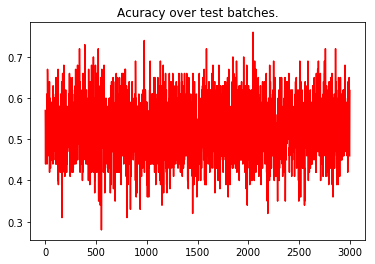

In [14]:
test_accuracy = np.zeros(TEST_ITERS)
for i in range(TEST_ITERS):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

### Save the work for future use

In [15]:
if TRAIN_ITERS > 0:
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
    # save the model to a file. Use minidb as the file format
    pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model.minidb"), pe_meta)
    print('Params saved to {}'.format(SAVE_FOLDER))

Params saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=2000000
